In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction, TimeSeriesTransformerModel
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy import stats

from core.dataset import MachoDataset
from core.trainer import PredictionTrainer, ClassificationTrainer
from core.model import ClassificationModel

/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True

In [5]:
config = {
    'random_seed': random_seed,
    'data_root': '/home/mrizhko/AML/contra_periodic/data/macho/',
    'balanced_data_root': '/home/mrizhko/AML/AstroML/data/macho-balanced/',
    'weights_path': '/home/mrizhko/AML/AstroML/weights/',

    # Time Series Transformer
    'lags': None,  # ?
    'distribution_output': 'normal',
    'num_static_real_features': 0,  # if 0 we don't use real features
    'num_time_features': 1,
    'd_model': 256,
    'decoder_layers': 4,
    'encoder_layers': 4,
    'dropout': 0,
    'encoder_layerdrop': 0,
    'decoder_layerdrop': 0,
    'attention_dropout': 0,
    'activation_dropout': 0,

    # Data
    'window_length': 200,
    'prediction_length': 10,  # 1 5 10 25 50

    # Training
    'batch_size': 512,
    'lr': 0.0001,
    'weight_decay': 0,
    'epochs_pre_training': 1000,
    'epochs_fine_tuning': 100,
    
    # Learning Rate Scheduler
    'factor': 0.3,
    'patience': 10,

    'mode': 'fine-tuning',  # 'pre-training' 'fine-tuning' 'both'
    'save_weights': False,
    'config_from_run': None,  # 'MeriDK/AstroML/qtun67bq'
}

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', device)

Using cuda


In [7]:
train_dataset = MachoDataset(config['balanced_data_root'], config['prediction_length'], mode='train')
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)

In [17]:
transformer_config = TimeSeriesTransformerConfig(
    prediction_length=config['prediction_length'],
    context_length=config['window_length'] - config['prediction_length'] - 7,  # 7 is max(lags) for default lags
    num_time_features=config['num_time_features'],
    num_static_real_features=config['num_static_real_features'],
    encoder_layers=config['encoder_layers'],
    decoder_layers=config['decoder_layers'],
    d_model=config['d_model'],
    distribution_output='normal',
    scaling=None,
    dropout=config['dropout'],
    encoder_layerdrop=config['encoder_layerdrop'],
    decoder_layerdrop=config['decoder_layerdrop'],
    attention_dropout=config['attention_dropout'],
    activation_dropout=config['activation_dropout']
)

In [18]:
embedder = TimeSeriesTransformerModel(transformer_config)

In [19]:
model = ClassificationModel(pretrained_model=embedder, device=device)
optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=config['factor'], patience=config['patience'], verbose=True)
criterion = nn.CrossEntropyLoss()

In [20]:
trainer = ClassificationTrainer(model=model, optimizer=optimizer, scheduler=scheduler, 
                                criterion=criterion, device=device)

In [21]:
trainer.train(train_dataloader, train_dataloader, epochs=1000)

Epoch 0: Train Loss 2.1046 	 Val Loss 2.0914 	                     Train Acc 0.1351 	 Val Acc 0.1256
Epoch 1: Train Loss 2.0804 	 Val Loss 2.0744 	                     Train Acc 0.1282 	 Val Acc 0.1246
Epoch 2: Train Loss 2.0714 	 Val Loss 2.0666 	                     Train Acc 0.1385 	 Val Acc 0.1417
Epoch 3: Train Loss 2.0669 	 Val Loss 2.0598 	                     Train Acc 0.1462 	 Val Acc 0.1528
Epoch 4: Train Loss 2.0559 	 Val Loss 2.0473 	                     Train Acc 0.1585 	 Val Acc 0.1825
Epoch 5: Train Loss 2.0374 	 Val Loss 2.0184 	                     Train Acc 0.1909 	 Val Acc 0.196
Epoch 6: Train Loss 2.001 	 Val Loss 1.9688 	                     Train Acc 0.2214 	 Val Acc 0.2504
Epoch 7: Train Loss 1.9501 	 Val Loss 1.915 	                     Train Acc 0.2498 	 Val Acc 0.2734
Epoch 8: Train Loss 1.8902 	 Val Loss 1.8483 	                     Train Acc 0.2671 	 Val Acc 0.3069
Epoch 9: Train Loss 1.8155 	 Val Loss 1.7625 	                     Train Acc 0.319 	 Val Acc 0

In [22]:
val_dataset = MachoDataset(config['balanced_data_root'], config['prediction_length'], mode='val')
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

(5.6521071791648865, 0.4575242718446602)


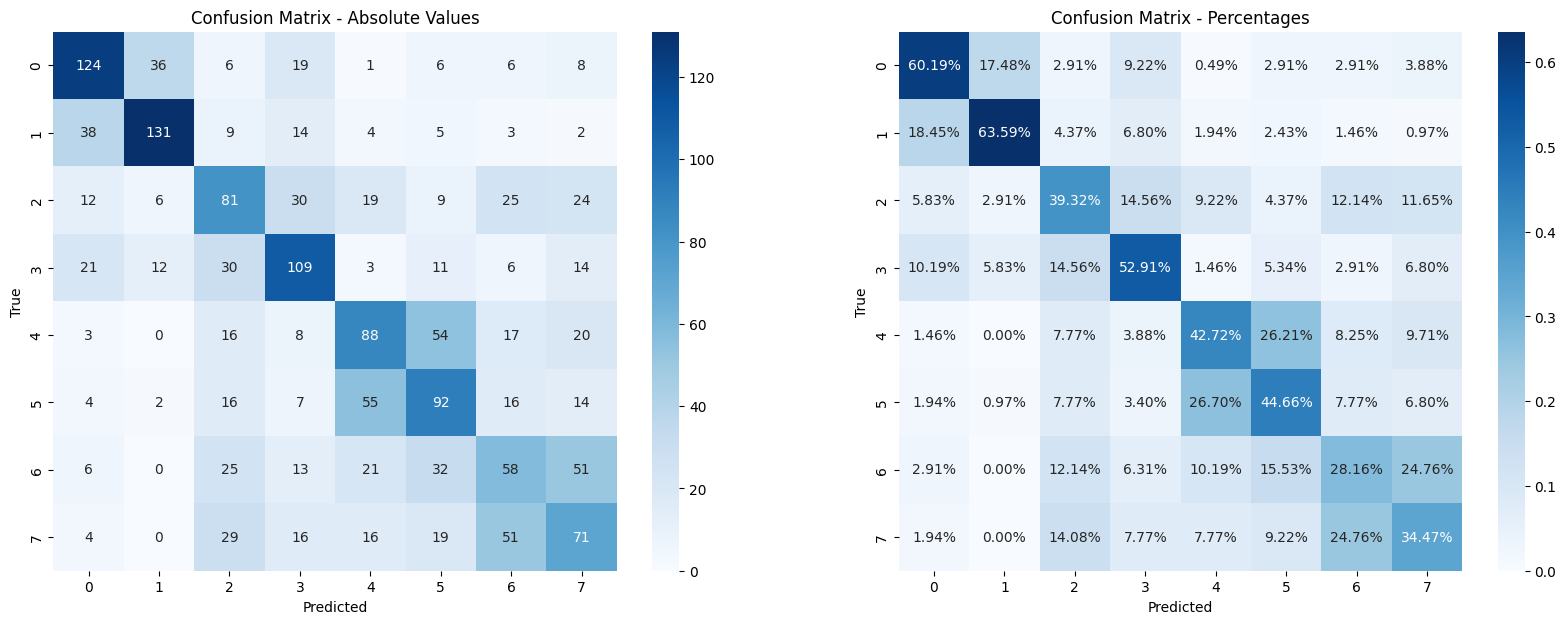

In [23]:
print(trainer.val_epoch(val_dataloader))
trainer.evaluate(val_dataloader)

(0.01166996881365776, 0.9995967741935484)


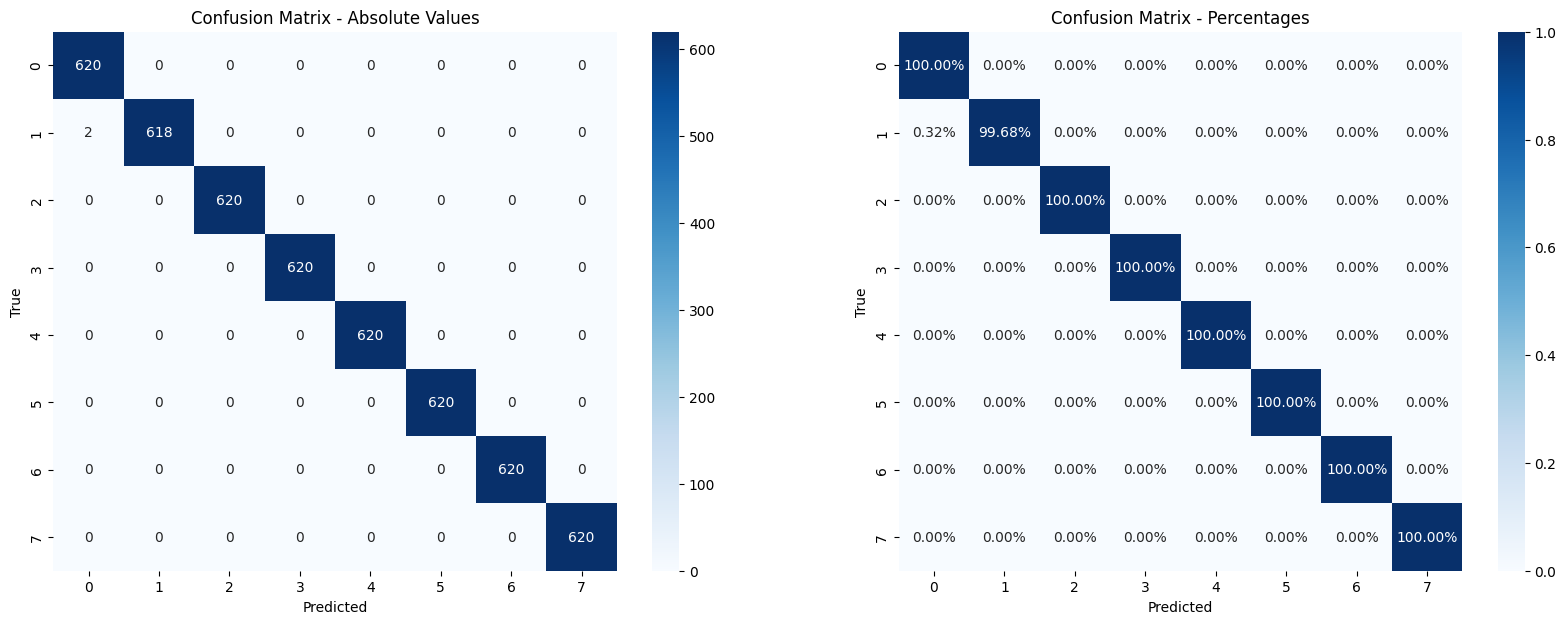

In [24]:
print(trainer.val_epoch(train_dataloader))
trainer.evaluate(train_dataloader)